<a href="https://colab.research.google.com/github/Luis-Pocholo-Caducio/MLBB_Highlights_Generator/blob/main/MLBB_Highlights_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture

!pip install pafy youtube-dl moviepy
!pip install tensorflow
!pip install keras
!pip install cv2
!pip install pygame
!pip install moviepy

In [3]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 7

DATASET_DIR = "/content/drive/MyDrive/mlbb dataset final"
CLASSES_LIST = ["farming", "team fight", "game ending", "lord", "turtle"]

In [6]:
def frames_extraction(video_path):

  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read()

    if not success:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

In [7]:
def create_dataset():

  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of Class: {class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frames_extraction(video_file_path)

      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  features = np.array(features)
  labels = np.array(labels)

  return features, labels, video_files_paths

In [8]:
# create the preprocessed dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: farming
Extracting Data of Class: team fight
Extracting Data of Class: game ending
Extracting Data of Class: lord
Extracting Data of Class: turtle


In [9]:
one_hot_encoded_labels = to_categorical(labels)

In [10]:
# split the data into train (75%) and Test Set (25%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                           test_size = 0.25, shuffle = True,
                                                                           random_state = seed_constant)

In [11]:
# CONSTRUCTING LRCN MODEL

def create_LRCN_model():

  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3,3), padding = 'same', activation = 'relu'),
                            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding = 'same', activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  #model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()

  return model

In [12]:
LRCN_model = create_LRCN_model()

print("Model created successfully")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 7, 64, 64, 16)       │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 7, 16, 16, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 7, 16, 16, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 7, 16, 16, 32)       │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 7, 4, 4, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 7, 4, 4, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 7, 4, 4, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 7, 2, 2, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 7, 2, 2, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 7, 2, 2, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 7, 1, 1, 64)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 7, 64)               │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,093 (285.52 KB)

 Trainable params: 73,093 (285.52 KB)

 Non-trainable params: 0 (0.00 B)

Model created successfully


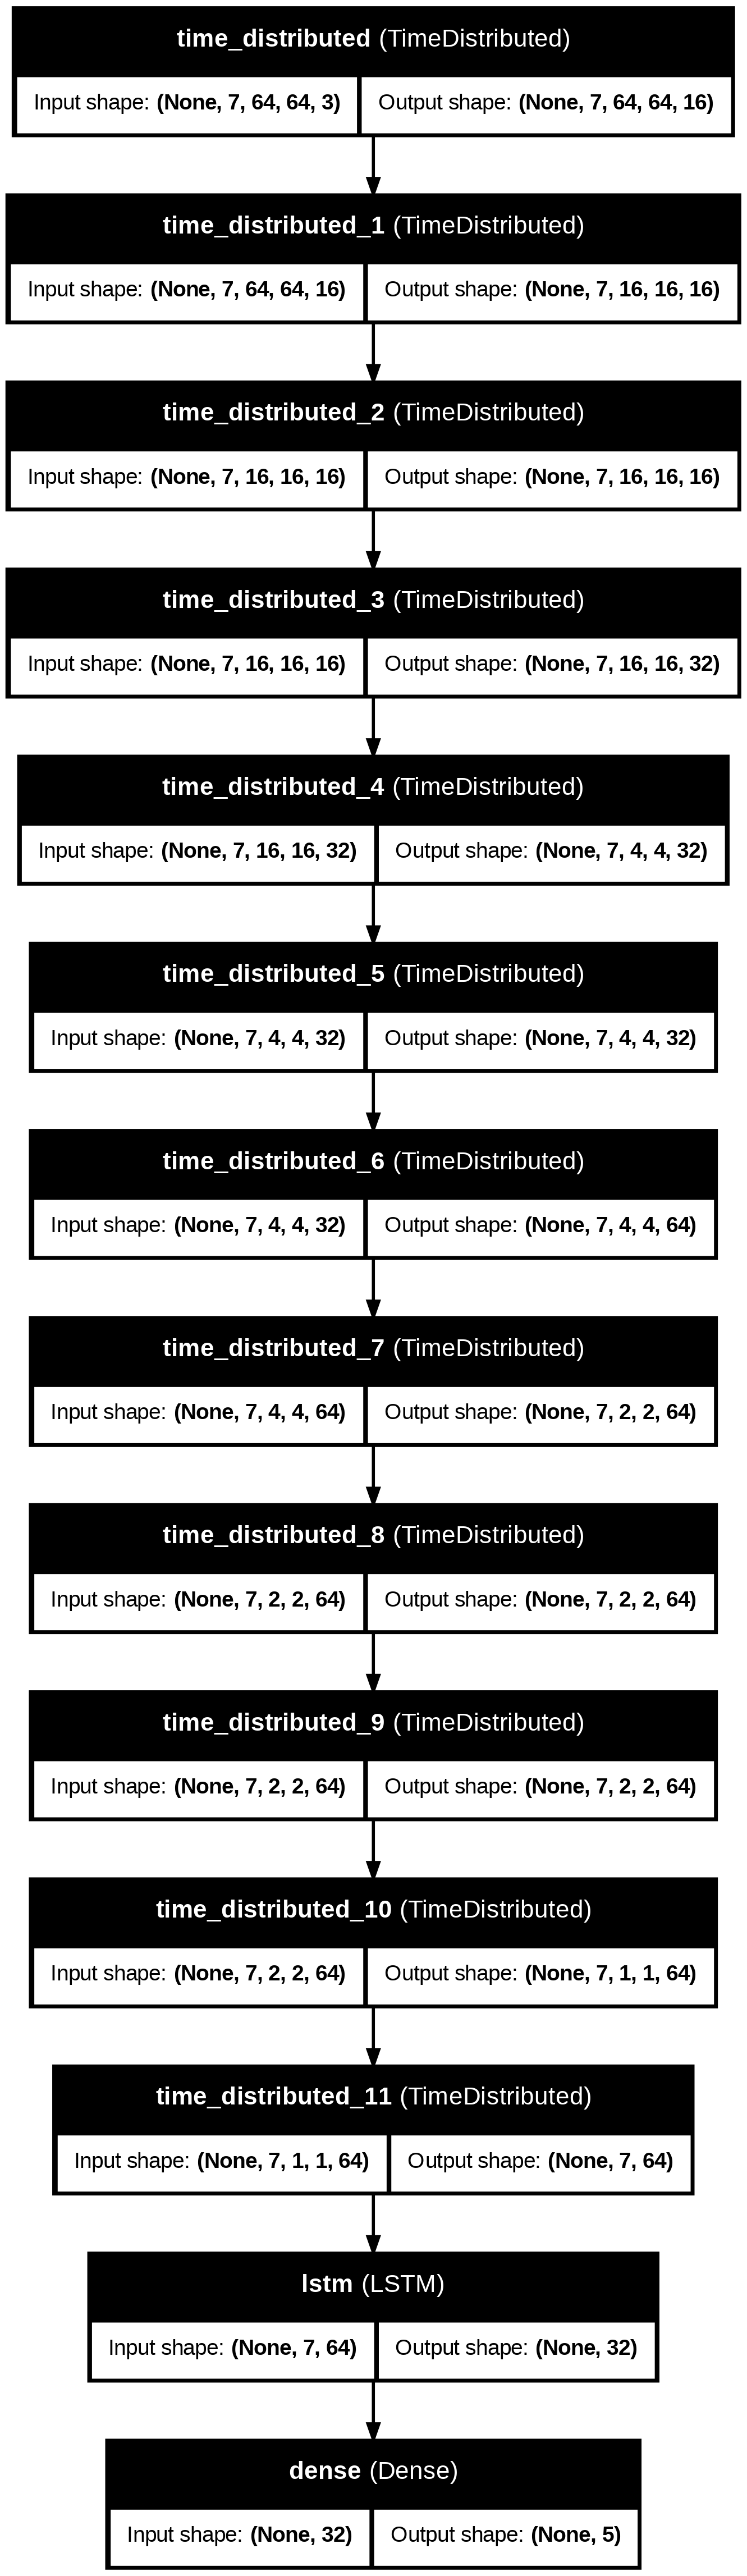

In [13]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [14]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 60, batch_size = 4,
                                              shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.3203 - loss: 1.5417 - val_accuracy: 0.3956 - val_loss: 1.4872
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2905 - loss: 1.4899 - val_accuracy: 0.3516 - val_loss: 1.4638
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3313 - loss: 1.4751 - val_accuracy: 0.3516 - val_loss: 1.4262
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3203 - loss: 1.4362 - val_accuracy: 0.3626 - val_loss: 1.3547
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2696 - loss: 1.3945 - val_accuracy: 0.5055 - val_loss: 1.3288
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4049 - loss: 1.3494 - val_accuracy: 0.4945 - val_loss: 1.2956
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4959 - loss: 1.2220 - val_accuracy: 0.5824 - val_loss: 1.1015
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5663 - loss: 1.0818 - val_accuracy: 0.5165 - 

In [15]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8686 - loss: 0.3901


In [16]:
# Saving the Model

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model__Date_Time){current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

In [17]:
# PLOTTING THE MODEL'S LOSS & ACCURACY CURVES

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

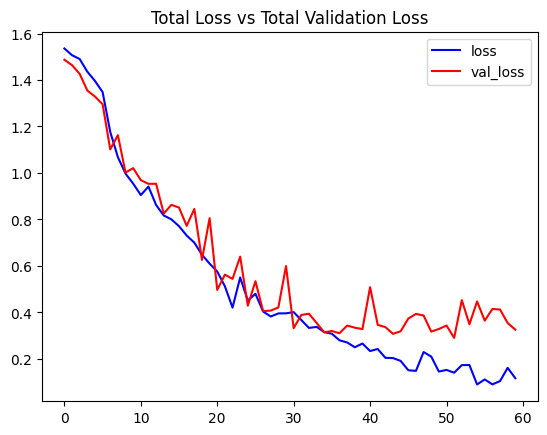

In [18]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

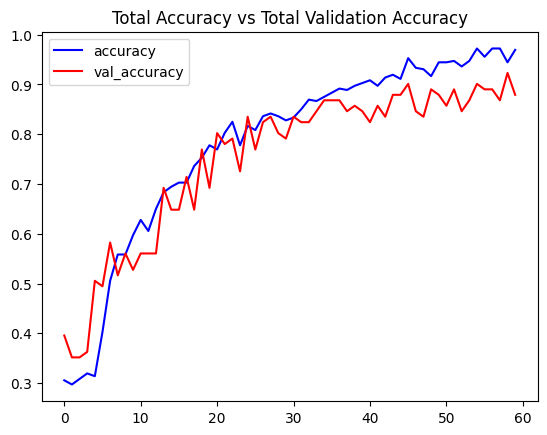

In [19]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [20]:
from keras.models import load_model
LRCN_model = load_model("/content/drive/MyDrive/LRCN_model__Date_Time)2025_01_03__16_04_05__Loss_0.45555490255355835__Accuracy_0.8796296119689941.h5")

In [21]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ITGhU0dOsQulCvRJyoV8")
project = rf.workspace("julianaworkspace-lueya").project("mlbb-banners-detection")
version = project.version(4)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MLBB-banners-detection-4 in yolov8:: 100%|██████████| 2368/2368 [00:00<00:00, 6150.09it/s]


In [22]:
!pip install ultralytics -q

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultra

In [ ]:
model = YOLO("yolov8s.pt")
model.train(data = "/content/MLBB-banners-detection-4/data.yaml" , epochs = 30)

100%|██████████| 21.5M/21.5M [00:00<00:00, 207MB/s]


Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/MLBB-banners-detection-4/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

train: Scanning /content/MLBB-banners-detection-4/train/labels.cache... 858 images, 1 backgrounds, 0 corrupt: 100%|██████████| 858/858 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/MLBB-banners-detection-4/valid/labels.cache... 208 images, 0 backgrounds, 0 corrupt: 100%|██████████| 208/208 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.78G      2.235      14.53      1.561         21        640: 100%|██████████| 54/54 [00:20<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

                   all        208        208      0.439      0.251      0.201      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.99G       1.19      2.458     0.9482         17        640: 100%|██████████| 54/54 [00:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]

                   all        208        208      0.455      0.475      0.425       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.03G      1.094      1.769     0.9292         16        640: 100%|██████████| 54/54 [00:17<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        208        208      0.448       0.66      0.591      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.06G      1.081      1.351     0.9051         19        640: 100%|██████████| 54/54 [00:17<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


                   all        208        208      0.499      0.644      0.618      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.07G      1.059      1.159     0.9059         11        640: 100%|██████████| 54/54 [00:16<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        208        208      0.632      0.758      0.706      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       4.1G      1.038      1.047      0.901         15        640: 100%|██████████| 54/54 [00:16<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        208        208      0.685       0.66      0.816      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       4.1G      1.044     0.9054     0.9138         19        640: 100%|██████████| 54/54 [00:16<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all        208        208      0.736      0.799      0.861      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.13G      1.041     0.9163     0.9069         25        640: 100%|██████████| 54/54 [00:16<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all        208        208      0.672      0.929      0.897      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.13G      1.013     0.8413      0.887         17        640: 100%|██████████| 54/54 [00:16<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        208        208      0.878      0.851      0.947      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.13G      1.019     0.7803     0.8988         25        640: 100%|██████████| 54/54 [00:17<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        208        208      0.835      0.828      0.912      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.13G      1.003     0.7452     0.8834         21        640: 100%|██████████| 54/54 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        208        208      0.833      0.905      0.953      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.13G      0.992     0.7134     0.8837         22        640: 100%|██████████| 54/54 [00:16<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

                   all        208        208      0.909       0.86      0.967      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.13G     0.9599     0.6617     0.8881         15        640: 100%|██████████| 54/54 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


                   all        208        208      0.865      0.859       0.95      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.13G     0.9408     0.6472     0.8806         23        640: 100%|██████████| 54/54 [00:16<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        208        208      0.916      0.896      0.975       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.13G     0.9544     0.6258     0.8704         16        640: 100%|██████████| 54/54 [00:16<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]

                   all        208        208      0.853      0.918      0.978      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.13G     0.9548      0.598     0.8733         15        640: 100%|██████████| 54/54 [00:16<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]

                   all        208        208      0.935      0.912      0.981      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.13G     0.9402     0.6011     0.8752         18        640: 100%|██████████| 54/54 [00:16<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]

                   all        208        208      0.876      0.961      0.985      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.13G     0.9347     0.5836     0.8743         21        640: 100%|██████████| 54/54 [00:16<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        208        208      0.964       0.91      0.978      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.13G     0.9072     0.5642     0.8671         15        640: 100%|██████████| 54/54 [00:16<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

                   all        208        208      0.943      0.911      0.986      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.13G      0.891     0.5331     0.8721         23        640: 100%|██████████| 54/54 [00:16<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]

                   all        208        208      0.945      0.908       0.99      0.751


In [ ]:
%%capture
!pip install moviepy

def predict_teamfights(video_file_path, SEQUENCE_LENGTH):
    import cv2
    import numpy as np
    from moviepy.video.io.VideoFileClip import VideoFileClip
    from moviepy.video.io.VideoFileClip import VideoFileClip
    from collections import deque

    video_reader = cv2.VideoCapture(video_file_path)
    target_class_name = "team fight"

    if not video_reader.isOpened():
        raise FileNotFoundError(f"Input video file {video_file_path} could not be opened.")

    fps = video_reader.get(cv2.CAP_PROP_FPS)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    video_duration = frame_count / fps

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    detected_intervals = []
    is_detecting = False
    start_time = None

    while video_reader.isOpened():
        current_frame_pos = video_reader.get(cv2.CAP_PROP_POS_FRAMES)
        current_time = current_frame_pos / fps

        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            if predicted_class_name == target_class_name:
                if not is_detecting:
                    start_time = current_time
                    is_detecting = True
            else:
                if is_detecting:
                    detected_intervals.append((start_time, current_time))
                    is_detecting = False

    if is_detecting:
        detected_intervals.append((start_time, video_duration))

    video_reader.release()

    return detected_intervals


In [ ]:
from typing import List, Tuple, Dict
import cv2
import numpy as np
from dataclasses import dataclass
from pathlib import Path

@dataclass
class HighlightSegment:
    start_time: float
    end_time: float
    priority_score: int
    banners: List[str]


def detect_banners_in_intervals(
    video_path: str,
    team_fight_intervals: List[Tuple[float, float]],
    banner_model: any,
    confidence_threshold: float = 0.8,
    verbose: bool = False
) -> List[HighlightSegment]:
    priority_dict = {
        'Savage': 13,
        'Maniac': 12,
        'TripleKill': 11,
        'DoubleKill': 10,
        'FirstBlood': 9,
        'ShutDown': 8,
        'Legendary': 7,
        'GodLike': 6,
        'MonsterKill': 5,
        'Unstoppable': 4,
        'MegaKill': 3,
        'KillingSpree': 2,
        'HasSlain': 1,
        'WipedOut': 0,
        'Destroyed': 0
    }

    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        raise RuntimeError(f"Failed to open video: {video_path}")

    try:
        fps = video_reader.get(cv2.CAP_PROP_FPS)
        highlight_segments = []

        for interval_idx, (start_time, end_time) in enumerate(team_fight_intervals, 1):
            if verbose:
                print(f"\nProcessing team fight {interval_idx}/{len(team_fight_intervals)}")

            detected_banners = set()
            total_priority = 0

            start_frame = int(start_time * fps)
            end_frame = int(end_time * fps)

            video_reader.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

            for frame_idx in range(start_frame, end_frame):
                ok, frame = video_reader.read()
                if not ok:
                    break

                results = banner_model(frame, verbose=False)

                for result in results:
                    boxes = result.boxes
                    for box in boxes:
                        class_name = banner_model.names[int(box.cls[0])]
                        confidence = float(box.conf[0])

                        if confidence > confidence_threshold:
                            if class_name not in detected_banners:
                                detected_banners.add(class_name)
                                banner_priority = priority_dict.get(class_name, 0)
                                total_priority += banner_priority

                                if verbose:
                                    print(f"New banner detected: {class_name} "
                                          f"(Priority: {banner_priority})")

                if verbose and (frame_idx - start_frame) % 30 == 0:
                    progress = (frame_idx - start_frame) / (end_frame - start_frame) * 100
                    print(f"Progress: {progress:.1f}%")

            if detected_banners:
                interval_duration = end_time - start_time
                if interval_duration < 2.0:
                    adjusted_start_time = max(0, start_time - 7.0)
                    #adjusted_end_time = end_time + 2.00
                    if verbose:
                        print(f"Banner detected, but interval too short ({interval_duration:.2f}s). "
                              f"Adjusting start time from {start_time:.2f}s to {adjusted_start_time:.2f}s")
                    start_time = adjusted_start_time
                    #end_time = adjusted_end_time


            highlight_segments.append(HighlightSegment(
                start_time=start_time,
                end_time=end_time,
                priority_score=total_priority,
                banners=list(detected_banners)
            ))

        #highlight_segments.sort(key=lambda x: x.priority_score, reverse=True)

        if verbose:
            print("\nHighlight Summary:")
            for i, segment in enumerate(highlight_segments, 1):
                print(f"\nHighlight {i}:")
                print(f"Time: {segment.start_time:.2f}s - {segment.end_time:.2f}s")
                print(f"Priority Score: {segment.priority_score}")
                print("Banners Detected:")
                for banner in segment.banners:
                    print(f"  - {banner}")
                print(f"Duration: {segment.end_time - segment.start_time:.2f}s")

        return highlight_segments

    finally:
        video_reader.release()

In [ ]:
def create_highlight_video(
    video_path: str,
    highlight_segments: List[HighlightSegment],
    output_path: str,
    min_priority_score: int = 1
) -> None:

    from moviepy.video.io.VideoFileClip import VideoFileClip
    from moviepy.editor import concatenate_videoclips
    from moviepy.editor import concatenate_videoclips, VideoFileClip

    valid_segments = [seg for seg in highlight_segments if seg.priority_score >= min_priority_score]

    if not valid_segments:
        print("No highlights meet the minimum priority score requirement.")
        return

    with VideoFileClip(video_path) as video:
        clips = []

        print("\nCreating highlight video with the following segments:")
        for i, segment in enumerate(valid_segments, 1):
            print(f"\nClip {i}:")
            print(f"Time: {segment.start_time:.2f}s - {segment.end_time:.2f}s")
            print(f"Priority Score: {segment.priority_score}")
            print("Banners:", ", ".join(segment.banners))

            clip = video.subclip(segment.start_time, segment.end_time)
            clips.append(clip)

        final_video = concatenate_videoclips(clips)
        final_video.write_videofile(
            output_path,
            codec="libx264",
            verbose=False,
            logger=None
        )

    print(f"\nHighlight video saved to: {output_path}")

In [ ]:
%%capture

input_video_path="/content/drive/MyDrive/ML input vids/Game ML - 2.mp4"
SEQUENCE_LENGTH = 30

detected_teamfights = predict_teamfights(input_video_path, SEQUENCE_LENGTH)

In [ ]:
print (detected_teamfights)

In [ ]:
banner_model = YOLO("/content/runs/detect/train/weights/best.pt")


highlight_segments = detect_banners_in_intervals(
    video_path="/content/drive/MyDrive/ML input vids/Game ML - 3.mp4",
    team_fight_intervals=detected_teamfights,
    banner_model=banner_model,
    verbose=True
)

In [ ]:
create_highlight_video(
    video_path="/content/drive/MyDrive/ML input vids/Game ML - 3.mp4",
    highlight_segments=highlight_segments,
    output_path="GAME ML 3_highlights_minPriority15.mp4",
    min_priority_score= 15
)